In [26]:
import transformers
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# BERT

In [41]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
le = LabelEncoder()

In [5]:
model = TFAutoModelForSequenceClassification.from_pretrained("models/bert")

Some layers from the model checkpoint at models/bert were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at models/bert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [42]:
test_dataset = pd.read_csv('datasets/test_level_a.csv')

tweets = test_dataset['tweet']
y_true = le.fit_transform(test_dataset['label'])

In [43]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'NOT': 0, 'OFF': 1}


In [8]:
tokenized = tokenizer(tweets.tolist(), return_tensors="np", padding="longest")
outputs = model(tokenized).logits

y_pred = np.argmax(outputs, axis=1)

## Metrics

In [70]:
def plot_conf_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    class_names = le.classes_ # name  of classes
    fig, ax = plt.subplots()
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g', ax=ax)
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels');

              precision    recall  f1-score   support

         NOT       0.87      0.90      0.89       620
         OFF       0.73      0.65      0.69       240

    accuracy                           0.83       860
   macro avg       0.80      0.78      0.79       860
weighted avg       0.83      0.83      0.83       860


accuracy: 0.8348837209302326
macro F1: 0.7881273595380858
weighted F1: 0.8321061153029763



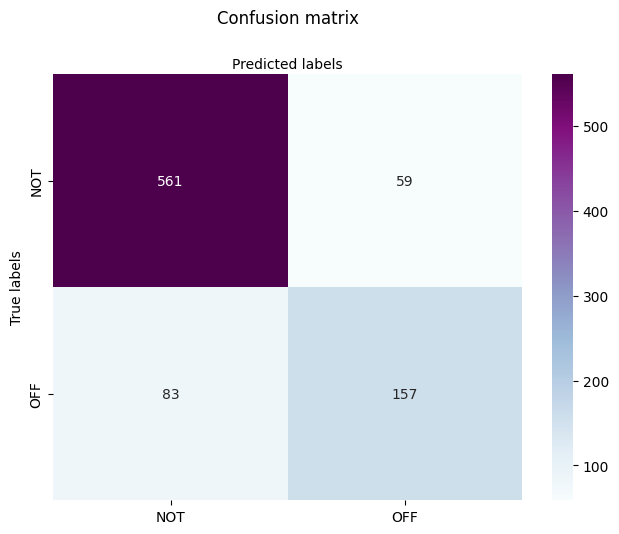

In [71]:
print(classification_report(y_true, y_pred, target_names=le.classes_))
print()
print("accuracy:", accuracy_score(y_true, y_pred))
print("macro F1:", f1_score(y_true, y_pred, average='macro'))
print("weighted F1:", f1_score(y_true, y_pred, average='weighted'))
print()
plot_conf_matrix(y_true, y_pred)

## Saving predictions

In [14]:
true_labels = test_dataset['label']
bert_labels = le.inverse_transform(y_pred)

In [35]:
name_dict = {
    'id': test_dataset['id'].values,
    'tweet': tweets.values,
    'true_label': true_labels,
    'bert_label': bert_labels
}

df = pd.DataFrame(name_dict)
df

,id,tweet,true_label,bert_label
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OFF,NOT
1,27014,"#ConstitutionDay is revered by Conservatives, ...",NOT,NOT
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT,NOT
3,13876,#Watching #Boomer getting the news that she is...,NOT,NOT
4,60133,#NoPasaran: Unity demo to oppose the far-right...,OFF,NOT
...,...,...,...,...
855,73439,#DespicableDems lie again about rifles. Dem Di...,OFF,NOT
856,25657,#MeetTheSpeakers 🙌 @USER will present in our e...,NOT,NOT
857,67018,3 people just unfollowed me for talking about ...,OFF,OFF
858,50665,#WednesdayWisdom Antifa calls the right fascis...,NOT,OFF


In [37]:
df.to_csv('predictions.csv', index=False)

## Wrong predictions

In [39]:
df_wrong = df[df.true_label != df.bert_label]
df_wrong

,id,tweet,true_label,bert_label
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OFF,NOT
4,60133,#NoPasaran: Unity demo to oppose the far-right...,OFF,NOT
6,96874,#RAP is a form of ART! Used to express yoursel...,NOT,OFF
7,65507,@USER Do you get the feeling he is kissing @US...,OFF,NOT
12,15565,#ConsTOO THE PLACE FOR FED UP CONSERVATIVES !!!,NOT,OFF
...,...,...,...,...
826,51762,#auspol I don't know why he is still in his j...,OFF,NOT
833,78688,"#ConfirmKavanugh now, stall tactics are DC cro...",OFF,NOT
850,31182,"1) Wow, safe sex! That's hot! We love a butch ...",NOT,OFF
855,73439,#DespicableDems lie again about rifles. Dem Di...,OFF,NOT


In [72]:
print(len(df_wrong[df_wrong.true_label == 'OFF']))
print(len(df_wrong[df_wrong.true_label == 'NOT']))

83
59
